In [1]:
using QuantEcon, CairoMakie, CUDA

In [2]:
CUDA.name(CUDA.device())

"NVIDIA GeForce RTX 3080 Ti Laptop GPU"

In [3]:
max_threads_per_block = CUDA.attribute(CUDA.device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

In [35]:
function params(;nk = 101)
    
    # Create NamedTuple
    p = (α = 0.33, # Capital share
         β = 0.9, # Discount factor
         A = 1.0, # TFP
         δ = 0.1, # Depreciation rate
         kmin = 0.75, # Minimum capital
         kmax = 1.25, # Maximum capital
         θ = 1.0, # Grid expansion parameter
         γ = 1.0, # Risk aversion
         kgrid = zeros(Float32, nk), # Capital grid
         maxiter = 1000, # Maximum number of iterations
         tol = 1e-6, # Tolerance
         print_skip = 10) # Print every print_skip iterations

    # Compute steady state capital
    Kss = ((p.A*p.α*p.β)/(1-p.β*(1.0-p.δ)))^(1/(1.0-p.α))

    # Create capital grid
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin*Kss .+ (p.kmax*Kss - p.kmin*Kss) * temp_grid.^p.θ
    
    # Return new NamedTuple
    p = (p..., kgrid = kgrid)
    
    return p
end

params (generic function with 1 method)

In [36]:
function max_kernel!(Vnew, Vmax, pol, nk)
    idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    if idx <= nk
        row_start = (idx - 1) * nk
        max_val = Vnew[row_start + 1]
        max_pos = 1
        for j in 2:nk
            if Vnew[row_start + j] > max_val
                max_val = Vnew[row_start + j]
                max_pos = j
            end
        end
        Vmax[idx] = max_val
        pol[idx] = max_pos
    end
    return
end

max_kernel! (generic function with 1 method)

In [77]:
function vfi(p::NamedTuple)

    # Create CuArrays
    V_d = CuArray{Float32}(zeros(length(p.kgrid)))
    Vnew_d = CuArray{Float32}(zeros(length(p.kgrid),length(p.kgrid)))
    Vmax_d = CuArray{Float32}(zeros(length(p.kgrid)))
    pol_d = CuArray{Int32}(undef, length(p.kgrid))

    # Get params
    maxiter = p.maxiter
    tol = p.tol
    γ = p.γ
    β = p.β
    nk = length(p.kgrid)
    kgrid_d = CuArray(p.kgrid)
    print_skip = p.print_skip
    
    # Initialise consumption
    cons_d = p.A .* kgrid_d.^p.α .+ (1 - p.δ) .* kgrid_d .- kgrid_d'
    
    # Run VFI
    solve!(V_d, Vnew_d, Vmax_d, cons_d, pol_d, kgrid_d; maxiter = maxiter, tol = tol, γ = γ, β = β, nk = nk, print_skip = print_skip)

    return V_d, pol_d, kgrid_d
end

function solve!(V, Vnew, Vmax, cons, pol, grid; maxiter, tol, γ, β, nk, print_skip = print_skip)
    error = tol + 1.0
    iter = 0
    pos_c = cons .> 0
    cons[.!pos_c] .= 1e-10
    c = (γ == 1.0 ? log.(cons) : (cons.^(1 - γ) .- 1) ./ (1 - γ))
    while ((error > tol) && (iter < maxiter))
        Vnew = c .+ β .* V'
        Vnew = reshape(Vnew', nk*nk, 1)
        block_size = max_threads_per_block
        num_blocks = ceil(Int, nk / block_size)
        @cuda threads=block_size blocks=num_blocks max_kernel!(Vnew, Vmax, pol, nk)
        error = maximum(abs.(Vmax .- V))
        V .= Vmax
        if iter % print_skip == 0
            println("-------------------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("-------------------------------")
    println("Converged in $iter iterations")
    return V, pol
end

solve! (generic function with 1 method)

-------------------------------
Iteration: 0, Error: 0.7284034
-------------------------------
Iteration: 10, Error: 0.0017657876
-------------------------------
Iteration: 20, Error: 0.00015854836
-------------------------------
Iteration: 30, Error: 3.4093857e-5
-------------------------------
Iteration: 40, Error: 1.1980534e-5
-------------------------------
Iteration: 50, Error: 4.23193e-6
-------------------------------
Iteration: 60, Error: 1.6093254e-6
-------------------------------
Converged in 67 iterations
  0.143737 seconds (11.65 k allocations: 893.234 KiB)


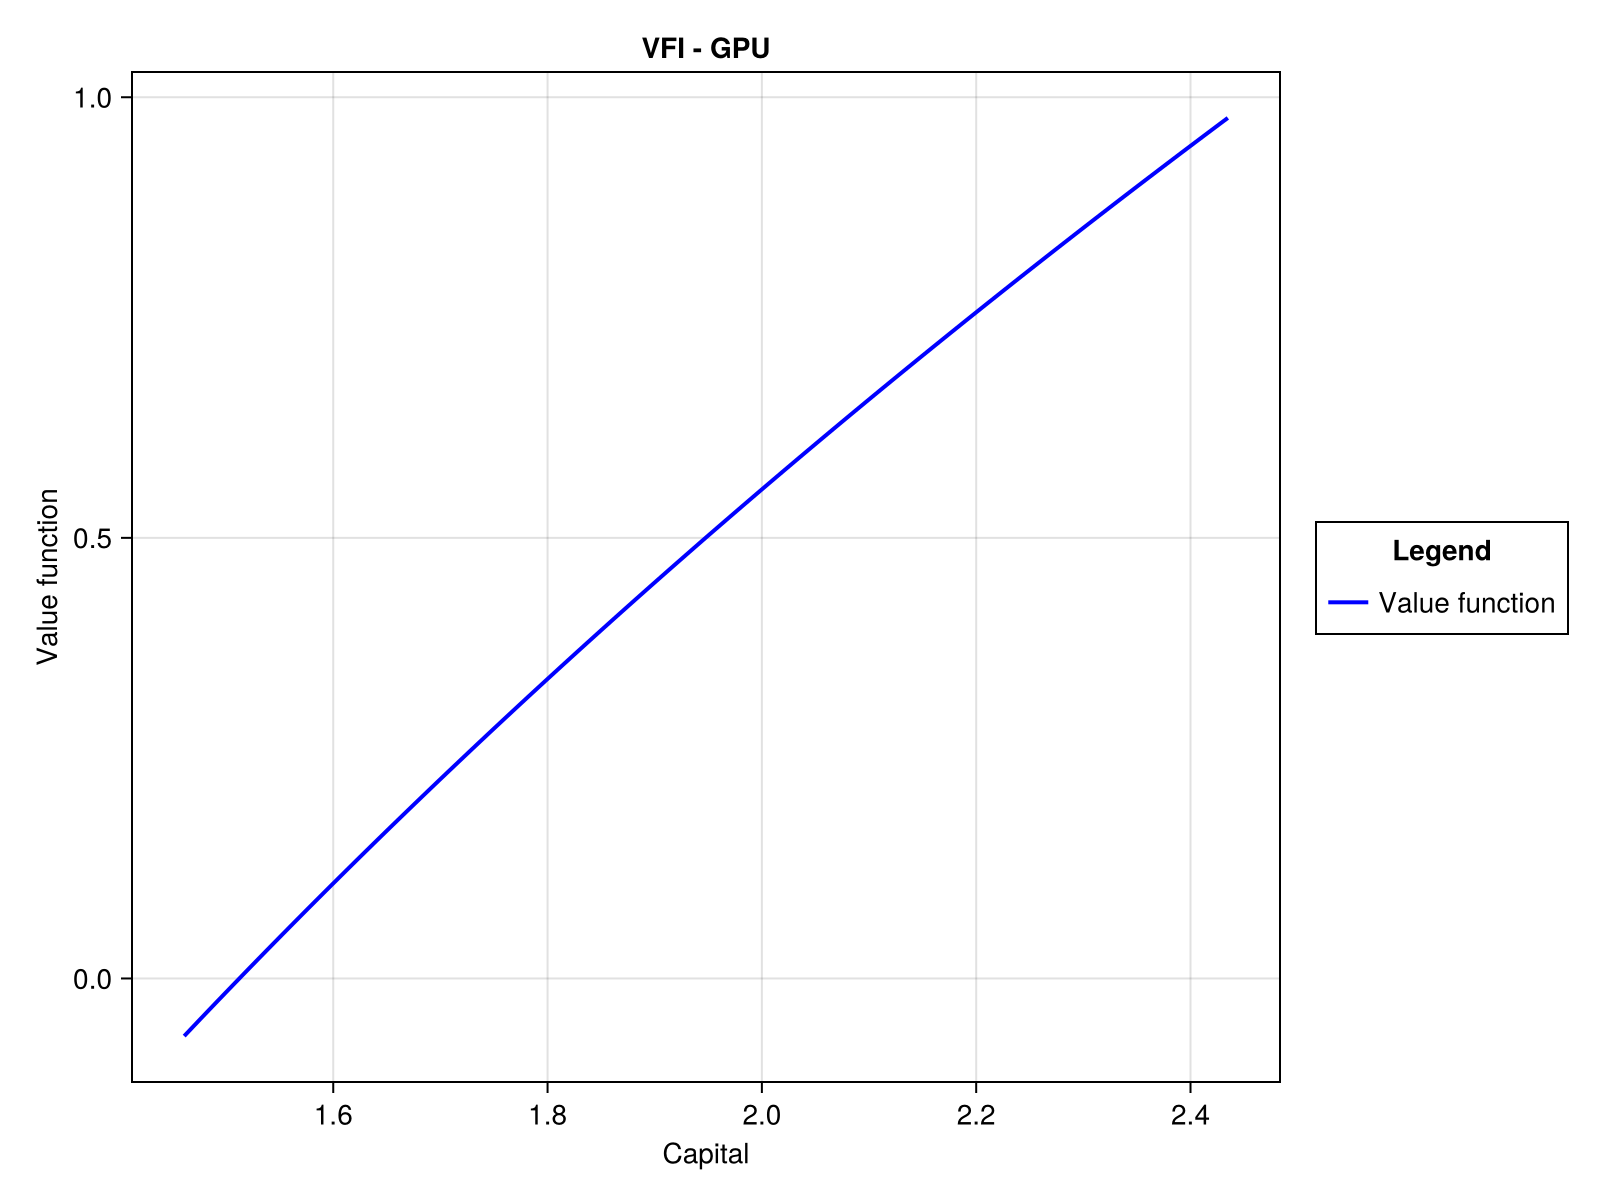

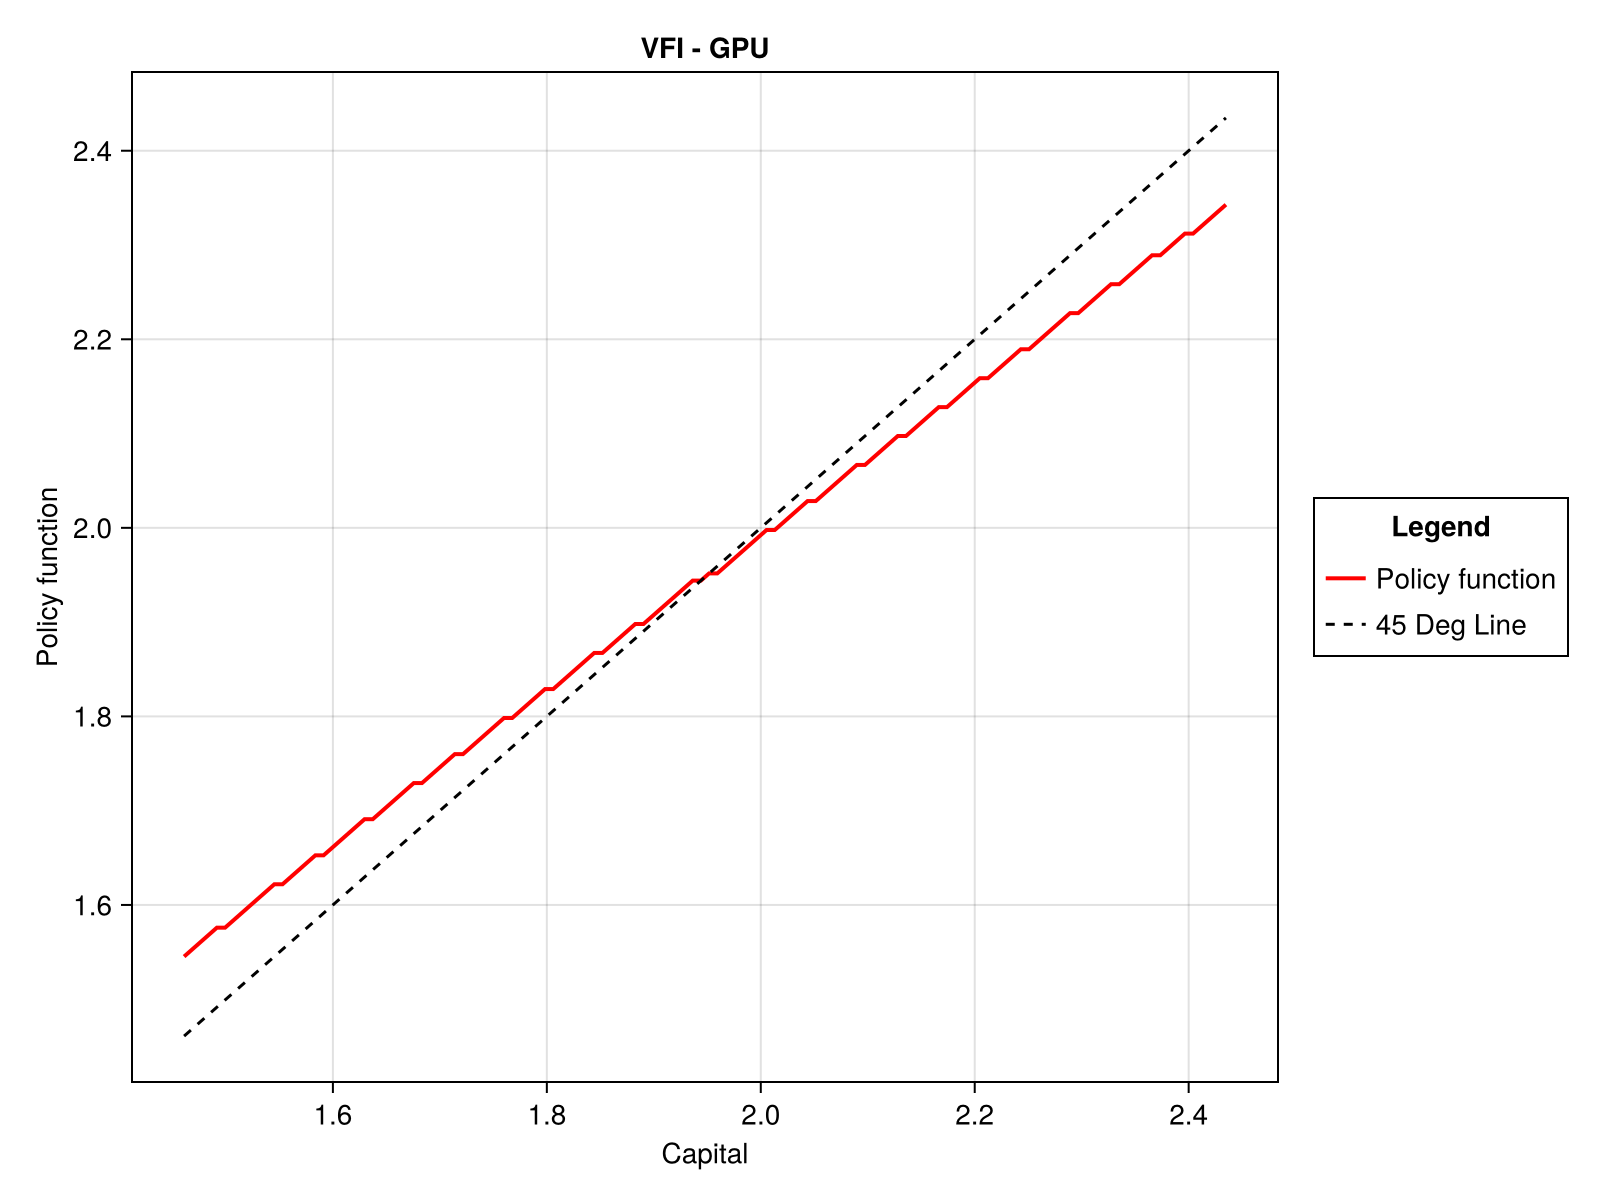

In [81]:
psmall = params(nk = 128)

@time begin
    v_d_128, pol_d_128, grid_d_128 = vfi(psmall)
end

v_128 = Array(v_d_128)
p_128 = Array(pol_d_128)
g_128 = Array(grid_d_128)

fig_v_128 = Figure(size = (800,600))
ax_v_128 = Axis(fig_v_128[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_128, g_128, v_128, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_128[1,2], ax_v_128, "Legend", orientation = :vertical)
display(fig_v_128)

fig_p_128 = Figure(size = (800,600))
ax_p_128 = Axis(fig_p_128[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_128, g_128, g_128[p_128], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_128, g_128, g_128, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_128[1,2], ax_p_128, "Legend", orientation = :vertical)
fig_p_128

-------------------------------
Iteration: 0, Error: 0.7284034
-------------------------------
Iteration: 10, Error: 0.001770258
-------------------------------
Iteration: 20, Error: 0.00015497208
-------------------------------
Iteration: 30, Error: 3.582239e-5
-------------------------------
Iteration: 40, Error: 1.180172e-5
-------------------------------
Iteration: 50, Error: 4.23193e-6
-------------------------------
Iteration: 60, Error: 1.5497208e-6
-------------------------------
Converged in 66 iterations
  0.238942 seconds (14.87 k allocations: 12.830 MiB)


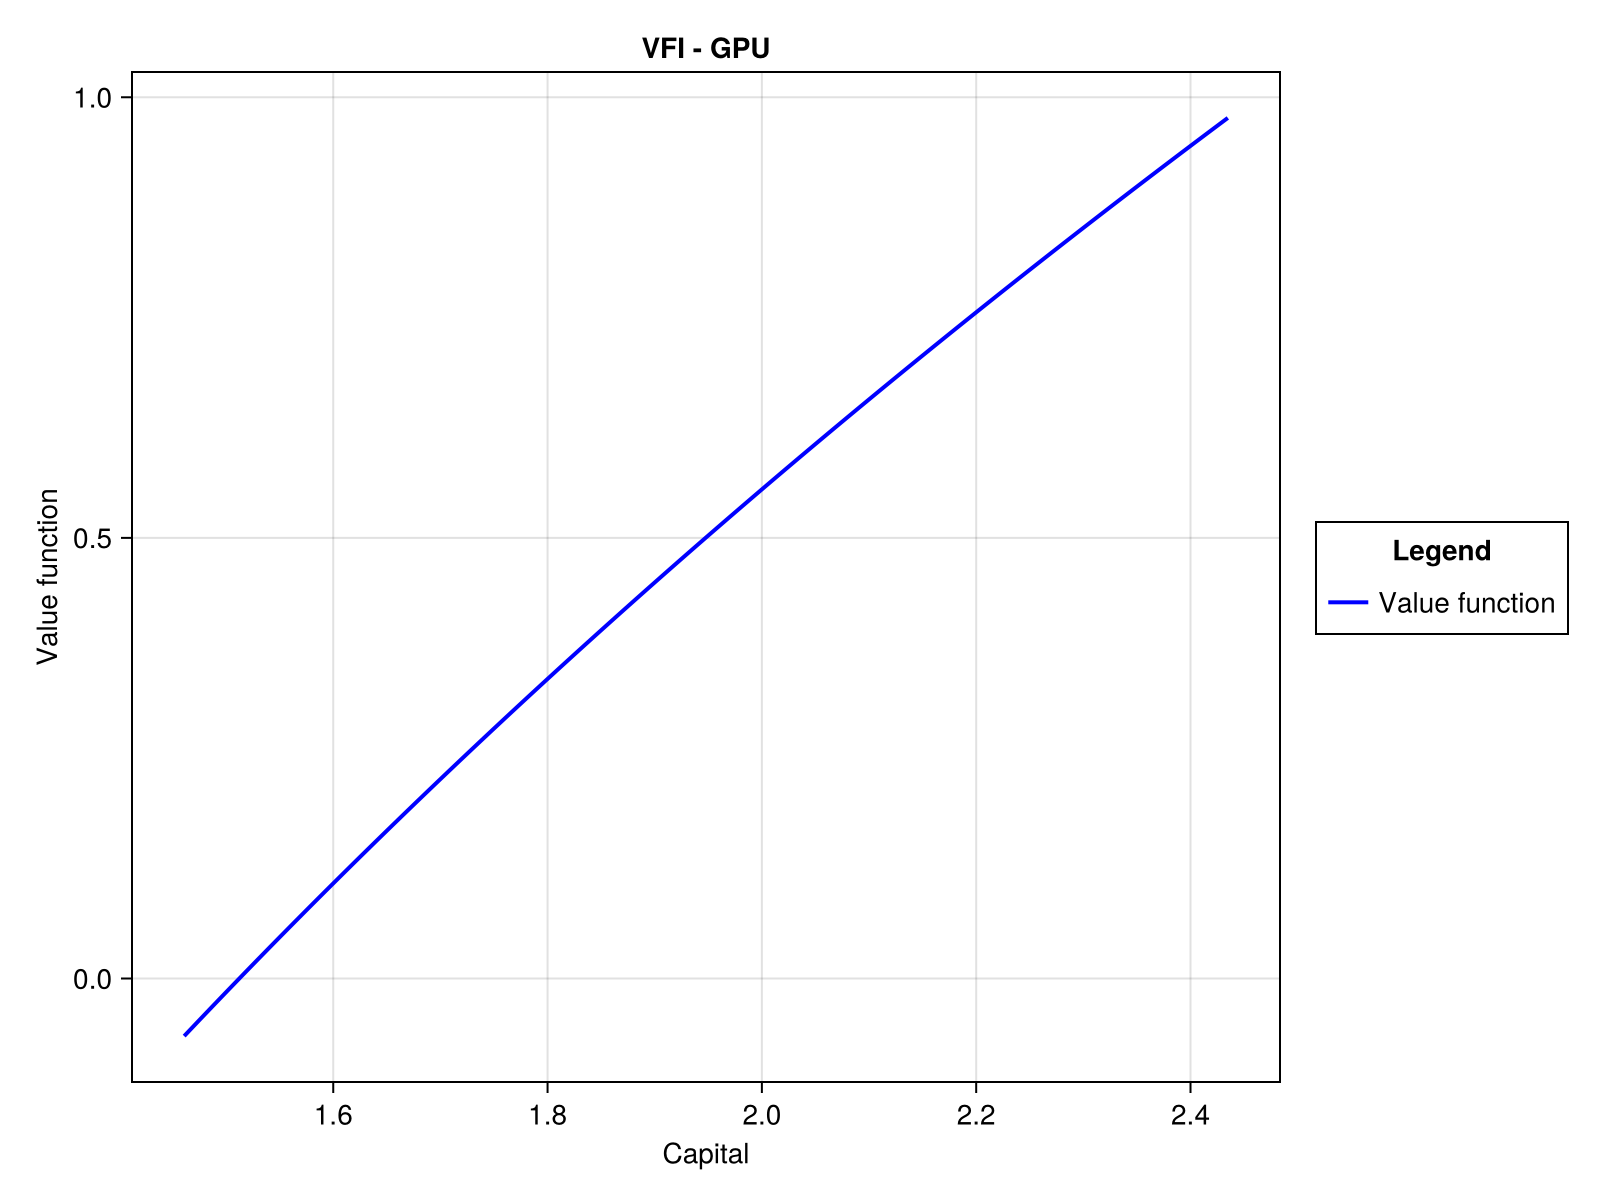

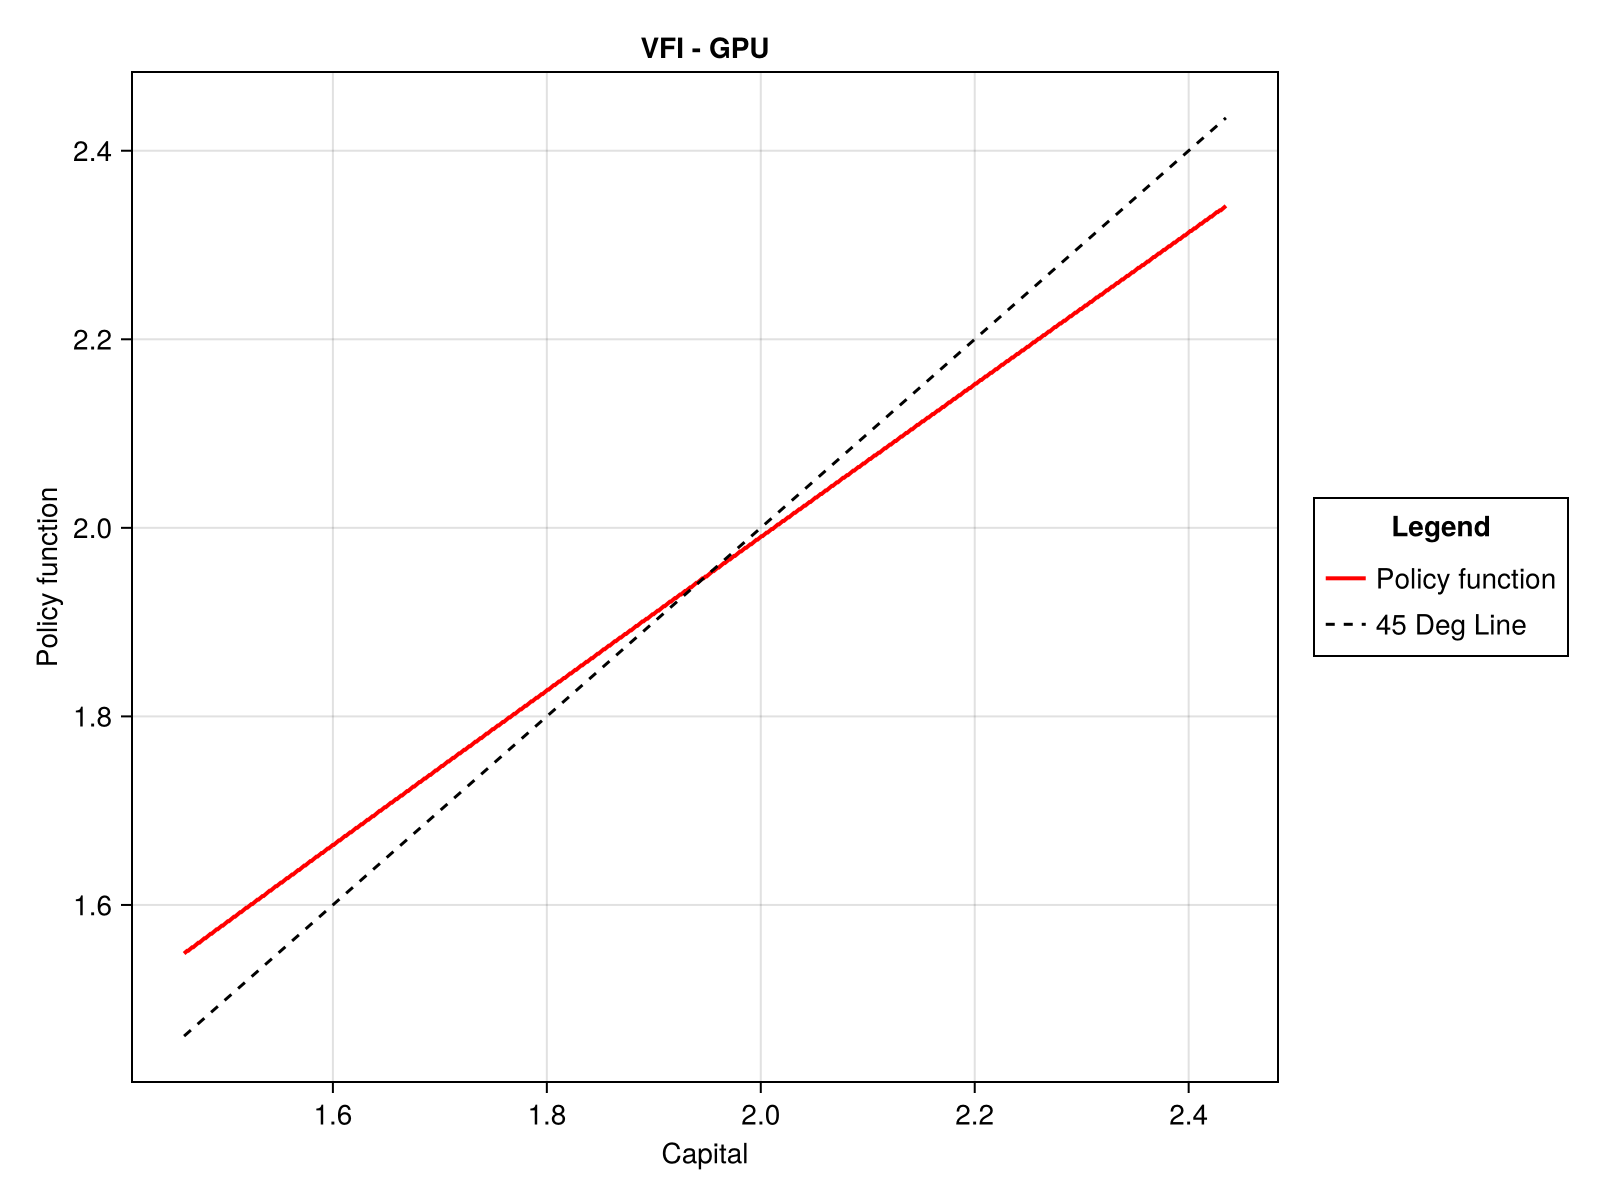

In [82]:
pbig = params(nk = 1024)

@time begin
    v_d_1024, pol_d_1024, grid_d_1024 = vfi(pbig)
end

v_1024 = Array(v_d_1024)
p_1024 = Array(pol_d_1024)
g_1024 = Array(grid_d_1024)

fig_v_1024 = Figure(size = (800,600))
ax_v_1024 = Axis(fig_v_1024[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_1024, g_1024, v_1024, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_1024[1,2], ax_v_1024, "Legend", orientation = :vertical)
display(fig_v_1024)

fig_p_1024 = Figure(size = (800,600))
ax_p_1024 = Axis(fig_p_1024[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_1024, g_1024, g_1024[p_1024], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_1024, g_1024, g_1024, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_1024[1,2], ax_p_1024, "Legend", orientation = :vertical)
fig_p_1024

-------------------------------
Iteration: 0, Error: 0.7284034
-------------------------------
Iteration: 10, Error: 0.001770258
-------------------------------
Iteration: 20, Error: 0.00015491247
-------------------------------
Iteration: 30, Error: 3.5762787e-5
-------------------------------
Iteration: 40, Error: 1.1742115e-5
-------------------------------
Iteration: 50, Error: 4.172325e-6
-------------------------------
Iteration: 60, Error: 1.5497208e-6
-------------------------------
Converged in 66 iterations
  0.638354 seconds (19.23 k allocations: 193.103 MiB, 12.80% gc time)


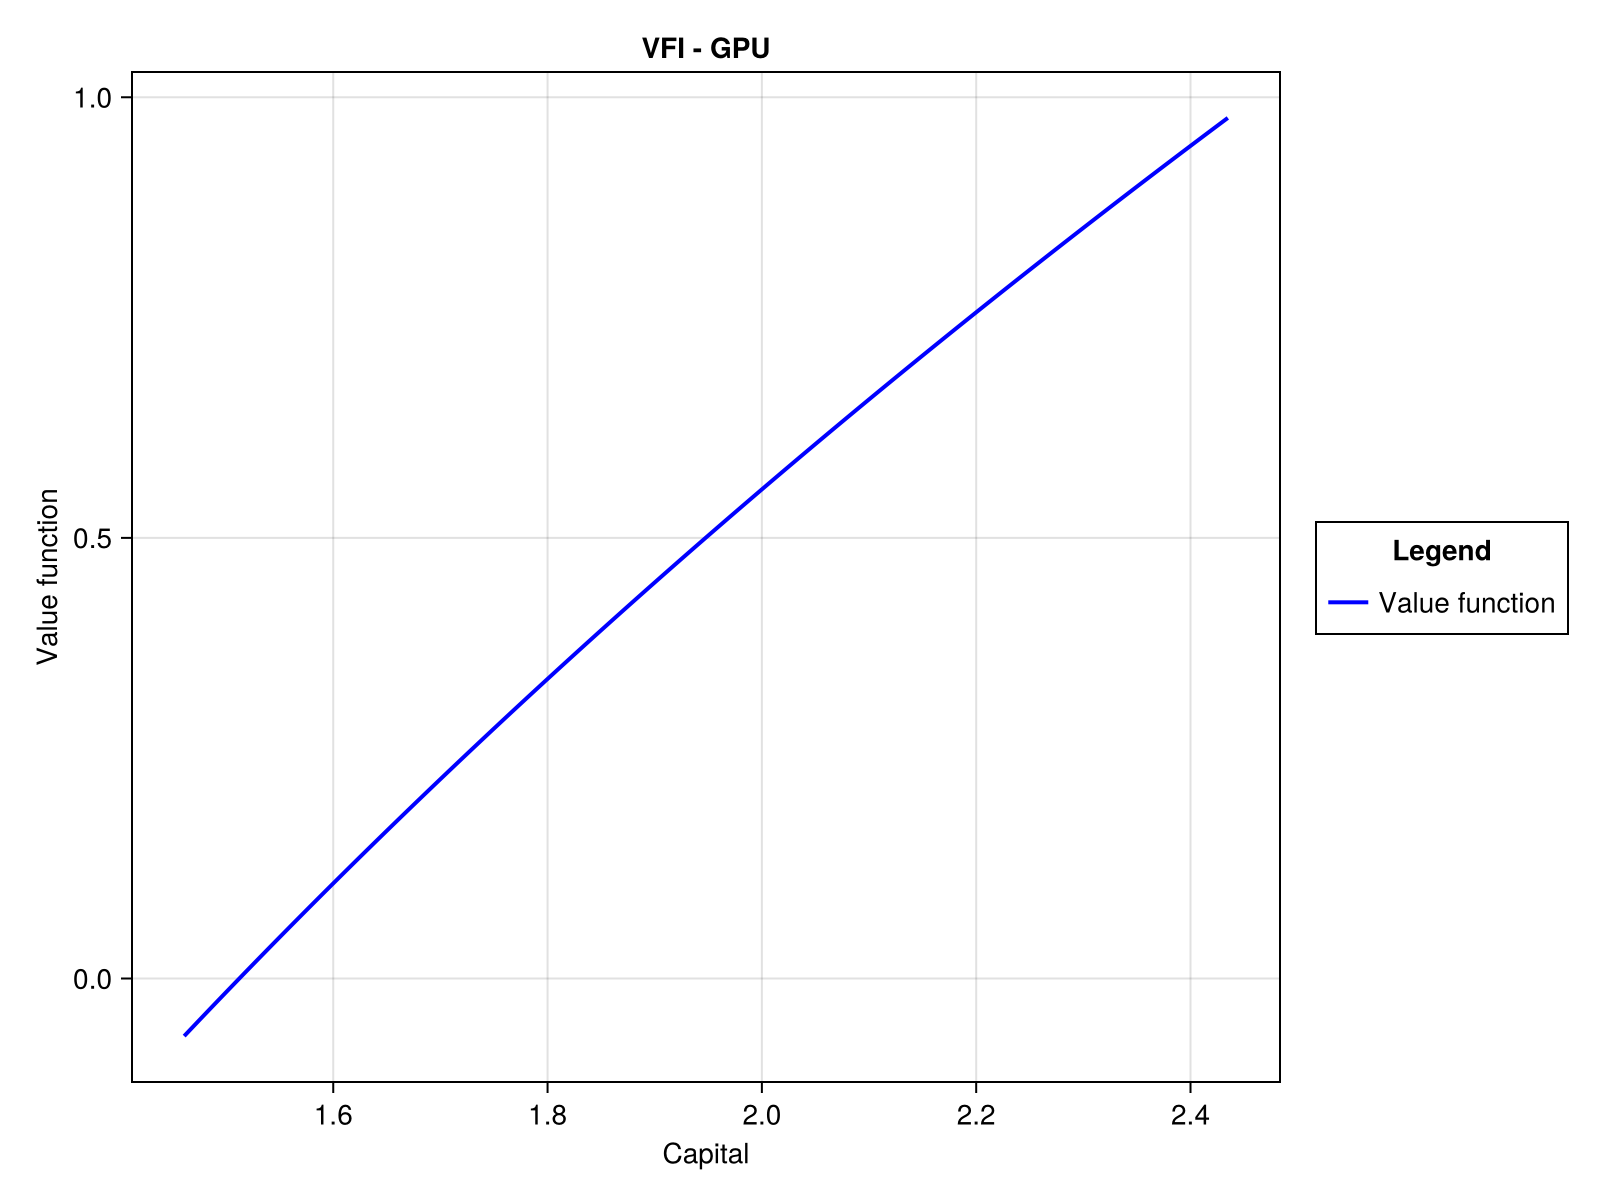

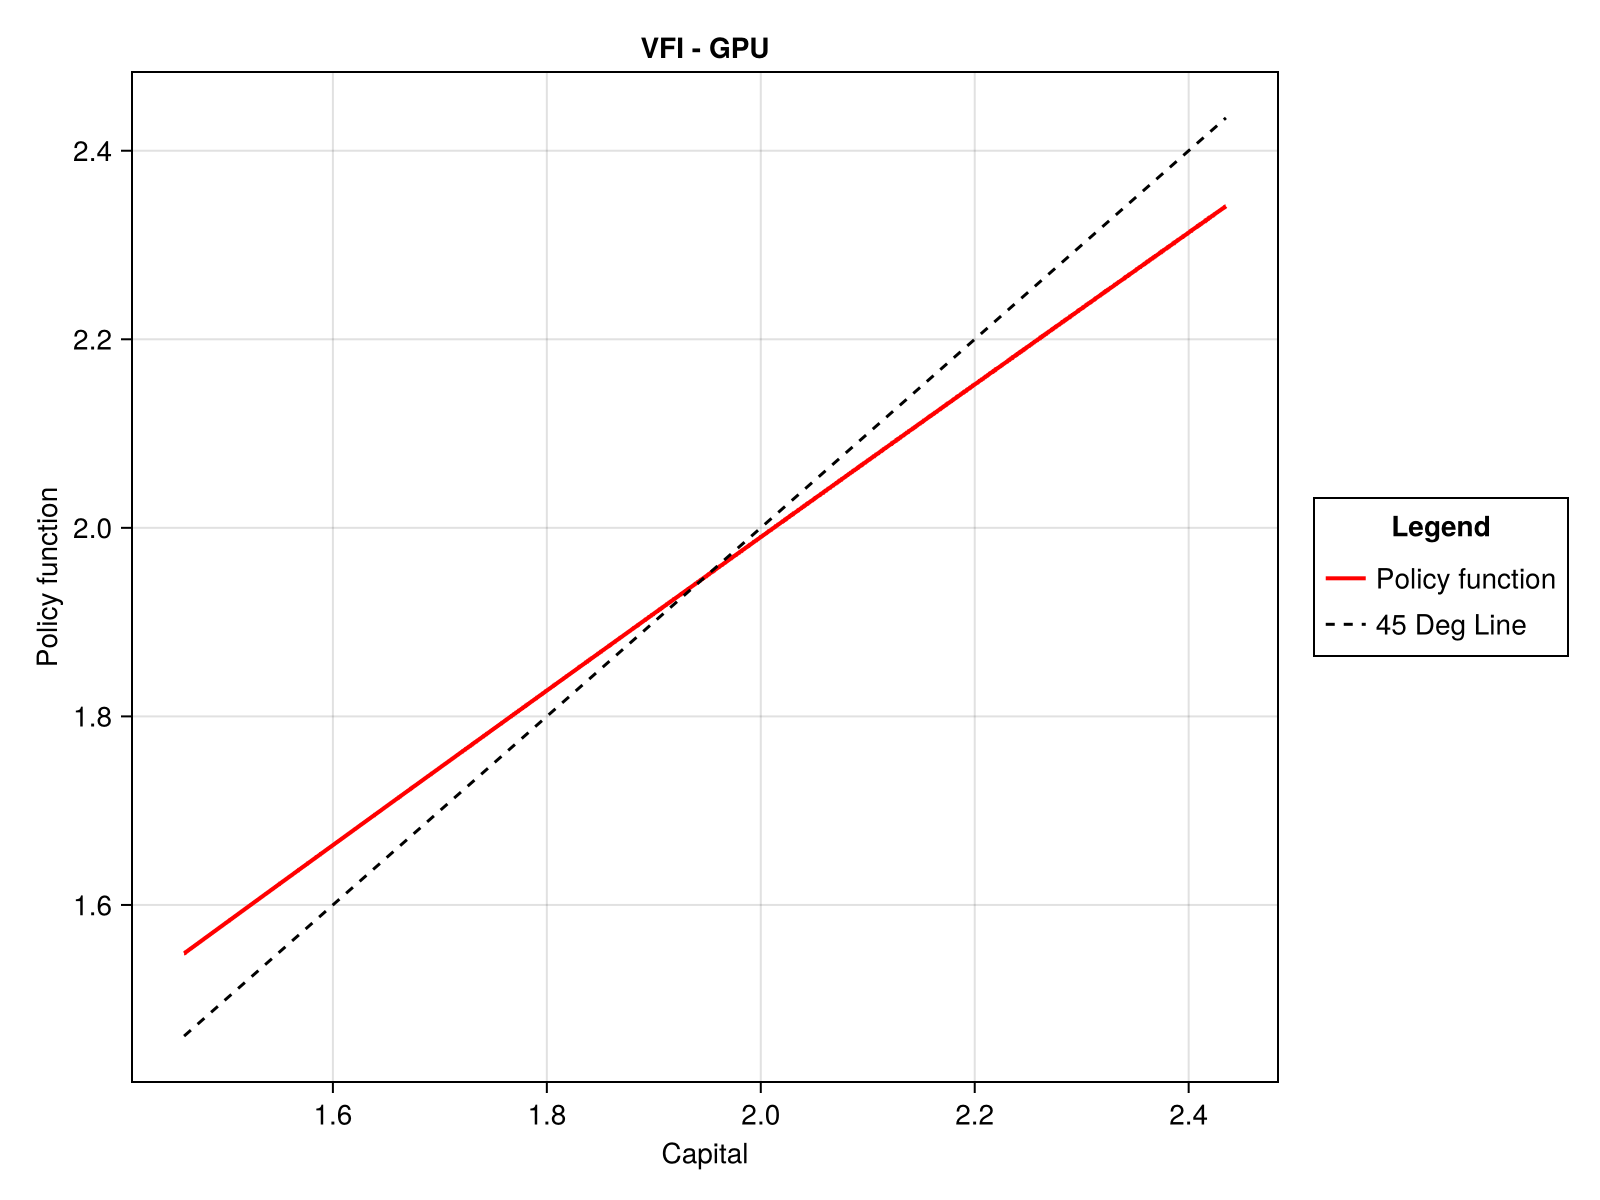

In [83]:
phuge = params(nk = 4096)

@time begin
    v_d_4096, pol_d_4096, grid_d_4096 = vfi(phuge)
end

v_4096 = Array(v_d_4096)
p_4096 = Array(pol_d_4096)
g_4096 = Array(grid_d_4096)

fig_v_4096 = Figure(size = (800,600))
ax_v_4096 = Axis(fig_v_4096[1,1], xlabel = "Capital", ylabel = "Value function", title = "VFI - GPU")
lines!(ax_v_4096, g_4096, v_4096, color = :blue, label = "Value function", linewidth = 2)
legendp = Legend(fig_v_4096[1,2], ax_v_4096, "Legend", orientation = :vertical)
display(fig_v_4096)

fig_p_4096 = Figure(size = (800,600))
ax_p_4096 = Axis(fig_p_4096[1,1], xlabel = "Capital", ylabel = "Policy function", title = "VFI - GPU")
lines!(ax_p_4096, g_4096, g_4096[p_4096], color = :red, linewidth = 2, label = "Policy function")
lines!(ax_p_4096, g_4096, g_4096, color = :black, label = "45 Deg Line", linestyle = :dash)
legendp = Legend(fig_p_4096[1,2], ax_p_4096, "Legend", orientation = :vertical)
fig_p_4096

In [76]:
function pars(;nk = 101, nz = 15)
    
    # Create NamedTuple
    p = (;α = 0.33, # Capital share
    β = 0.9, # Discount factor
    δ = 0.1, # Depreciation Rate
    A = 1.0, # TFP
    μ = 0.0, # Mean of AR(1) process
    σ = 0.003, # Standard deviation of AR(1) process
    ρ = 0.9, # Persistence of AR(1) process
    Π = zeros(Float32, nz, nz), # Transition matrix
    zgrid = zeros(Float32, nz), # Grid for productivity
    kgrid = zeros(Float32, nk), # Grid for capital
    kmin = 1e-2, # Minimum capital 
    kmax = 100.0, # Maximum capital
    θ = 1.0, # Grid expansion parameter
    γ = 1.0, # Risk aversion 
    maxiter = 1000, # Maximum number of iterations
    tol = 1e-6, # Tolerance
    print_skip = 10) # Print every print_skip iterations

    # Create grid for productivity
    mc = rouwenhorst(nz, p.μ, p.ρ, p.σ)
    Π = mc.p
    zgrid = exp.(mc.state_values)

    # Create grid for Capital
    temp_grid = LinRange(0, 1, nk)
    kgrid = p.kmin .+ (p.kmax .- p.kmin) .* temp_grid.^p.θ

    # Return new NamedTuple
    p = (p..., Π = Π, zgrid = zgrid, kgrid = kgrid)

    return p
end

test = pars(nk = 128, nz = 15)

(α = 0.33, β = 0.9, δ = 0.1, A = 1.0, μ = 0.0, σ = 0.003, ρ = 0.9, Π = [6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; … ; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5; 6.103515625e-5 0.0008544921875 … 0.0008544921875 6.103515625e-5], zgrid = [0.03457959025122844, 0.05594303083042085, 0.09050490985451279, 0.14641928737474275, 0.23687784176339377, 0.3832221350379456, 0.6199786509779679, 1.003004504503377, 1.6226656102869836, 2.625156388616362, 4.246990890177603, 6.870802707018247, 11.115618342377728, 17.982901911474734, 29.092826975250997], kgrid = [0.01, 0.7973228346456692, 1.5846456692913384, 2.3719685039370075, 3.1592913385826766, 3.946614173228346, 4.733937007874015, 5.521259842519685, 6.3085826771653535, 7.095905511811023  …  92.91409448818898, 93.70141732283464, 94.48874015748031, 95.27606299212599, 96.06338582677165, 96.85070866141731, 97.638031496063, 98.42535433070866, 99.21267